In [1]:
import pandas as pd
import numpy as np

## STEP 1.数据概览

In [2]:
df = pd.read_excel('./PYTHON-RFM实战数据.xlsx')
df

,品牌名称,买家昵称,付款日期,订单状态,实付金额,邮费,省份,城市,购买数量
0,数据不吹牛,叫我李2,2019-01-01 00:17:59.000,交易成功,186,6,上海,上海市,1
1,数据不吹牛,0cyb1992,2019-01-01 00:59:54.000,交易成功,145,0,广东省,广州市,1
2,数据不吹牛,萝污萌莉,2019-01-01 07:48:48.000,交易成功,194,8,山东省,东营市,1
3,数据不吹牛,atblovemyy,2019-01-01 09:15:49.000,付款以后用户退款成功，交易自动关闭,84,0,江苏省,镇江市,1
4,数据不吹牛,小星期鱼,2019-01-01 09:59:33.000,付款以后用户退款成功，交易自动关闭,74,0,上海,上海市,1
...,...,...,...,...,...,...,...,...,...
28828,数据不吹牛,nhuliy5,2019-06-30 22:22:09.000,交易成功,144,0,湖南省,长沙市,1
28829,数据不吹牛,2ganlin7,2019-06-30 22:33:42.773,交易成功,216,0,安徽省,滁州市,1
28830,数据不吹牛,点大a,2019-06-30 22:36:52.890,交易成功,231,0,湖北省,武汉市,1
28831,数据不吹牛,8陈爷558989,2019-06-30 22:44:38.392,交易成功,99,0,广东省,深圳市,2


#### 查看交易状态

In [3]:
df['订单状态'].unique()

array(['交易成功', '付款以后用户退款成功，交易自动关闭'], dtype=object)

In [5]:
df['订单状态'].value_counts()

交易成功                 27793
付款以后用户退款成功，交易自动关闭     1040
Name: 订单状态, dtype: int64

#### 查看数据类型

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28833 entries, 0 to 28832
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   品牌名称    28833 non-null  object        
 1   买家昵称    28833 non-null  object        
 2   付款日期    28833 non-null  datetime64[ns]
 3   订单状态    28833 non-null  object        
 4   实付金额    28833 non-null  int64         
 5   邮费      28833 non-null  int64         
 6   省份      28833 non-null  object        
 7   城市      28832 non-null  object        
 8   购买数量    28833 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 2.0+ MB


## STEP 2.数据清洗

#### 剔除退款

In [8]:
df = df[df['订单状态'] == '交易成功']

#### 关键字段提取

In [9]:
df = df[['买家昵称','付款日期','实付金额']]
df.head()

,买家昵称,付款日期,实付金额
0,叫我李2,2019-01-01 00:17:59,186
1,0cyb1992,2019-01-01 00:59:54,145
2,萝污萌莉,2019-01-01 07:48:48,194
5,重碎叠,2019-01-01 10:00:07,197
6,iho_jann,2019-01-01 10:00:08,168


#### R值构造

In [15]:
r = df.groupby('买家昵称')['付款日期'].max().reset_index()
r.head()

,买家昵称,付款日期
0,.blue_ram,2019-02-04 17:49:34.000
1,.christiny,2019-01-29 14:17:15.000
2,.willn1,2019-01-11 03:46:18.000
3,.托托m,2019-01-11 02:26:33.000
4,0000妮,2019-06-28 16:53:26.458


In [19]:
pd.to_datetime('2019-7-1') - r['付款日期']

0              146 days 06:10:26
1              152 days 09:42:45
2              170 days 20:13:42
3              170 days 21:33:27
4         2 days 07:06:33.542000
                  ...           
25415           84 days 15:17:00
25416           72 days 01:45:36
25417    11 days 19:33:29.411000
25418           24 days 12:45:08
25419   158 days 00:08:08.543000
Name: 付款日期, Length: 25420, dtype: timedelta64[ns]

In [35]:
r['R'] = (pd.to_datetime('2019-7-1') - r['付款日期']).dt.days
r = r[['买家昵称','R']]
r.head()

,买家昵称,R
0,.blue_ram,146
1,.christiny,152
2,.willn1,170
3,.托托m,170
4,0000妮,2


#### F值构造

在前面数据概览阶段，我们明确了“把单个用户一天内多次下单行为看作整体一次”的思路，所以，引入一个精确到天的日期标签，依照“买家昵称”和“日期标签”进行分组，把每个用户一天内的多次下单行为合并，再统计购买次数：

In [38]:
#引入日期标签辅助列
df['日期标签'] = df['付款日期'].astype(str).str[:10]

#把单个用户一天内订单合并
dup_f = df.groupby(['买家昵称','日期标签'])['付款日期'].count().reset_index()

#对合并后的用户统计频数
f = dup_f.groupby('买家昵称')['付款日期'].count().reset_index()
f.columns = ['买家昵称','F']

In [39]:
f

,买家昵称,F
0,.blue_ram,1
1,.christiny,1
2,.willn1,1
3,.托托m,1
4,0000妮,1
...,...,...
25415,龙火师,1
25416,龙魔鬼女,1
25417,龟mil宝,2
25418,！谢鹏逗逼？,1


#### M值构造

上一步计算出了每个用户购买频次，这里我们只需要得到每个用户总金额，再用总金额除以购买频次，就能拿到用户平均支付金额：

In [41]:
sum_m = df.groupby('买家昵称')['实付金额'].sum().reset_index()
sum_m.columns = ['买家昵称','总支付金额']

com_m = pd.merge(sum_m,f,left_on = '买家昵称',right_on = '买家昵称',how = 'inner')

#计算用户平均支付金额
com_m['M'] = com_m['总支付金额'] / com_m['F']
com_m.head()

,买家昵称,总支付金额,F,M
0,.blue_ram,49,1,49.0
1,.christiny,183,1,183.0
2,.willn1,34,1,34.0
3,.托托m,37,1,37.0
4,0000妮,164,1,164.0


#### 三个值合并

In [43]:
rfm = pd.merge(r,com_m,left_on = '买家昵称',right_on = '买家昵称',how = 'inner')
rfm = rfm[['买家昵称','R','F','M']]
rfm

,买家昵称,R,F,M
0,.blue_ram,146,1,49.0
1,.christiny,152,1,183.0
2,.willn1,170,1,34.0
3,.托托m,170,1,37.0
4,0000妮,2,1,164.0
...,...,...,...,...
25415,龙火师,84,1,175.0
25416,龙魔鬼女,72,1,87.0
25417,龟mil宝,11,2,248.5
25418,！谢鹏逗逼？,24,1,137.0


## STEP 3.维度确认（不涉及代码）

维度确认的核心是分值确定，按照设定的标准，我们给每个消费者的R/F/M值打分，分值的大小取决于我们的偏好，即我们越喜欢的行为，打的分数就越高：

以R值为例，R代表了用户有多少天没来下单，这个值越大，用户流失的可能性越大，我们当然不希望用户流失，所以R越大，分值越小。
F值代表了用户购买频次，M值则是用户平均支付金额，这两个指标是越大越好，即数值越大，得分越高。

RFM模型中打分一般采取5分制，有两种比较常见的方式，一种是按照数据的分位数来打分，另一种是依据数据和业务的理解，进行分值的划分。这里希望同学们加深对数据的理解，进行自己的分值设置，所以讲述过程中使用的是第二种，即提前制定好不同数值对应的分值。

## STEP 4.分值计算

#### R值计算

R值根据行业经验，设置为30天一个跨度，区间左闭右开;

In [44]:
rfm['R-SCORE'] = pd.cut(rfm['R'],bins = [0,30,60,90,120,1000000],labels = [5,4,3,2,1],right = False).astype(float)
rfm.head()

,买家昵称,R,F,M,R-SCORE
0,.blue_ram,146,1,49.0,1.0
1,.christiny,152,1,183.0,1.0
2,.willn1,170,1,34.0,1.0
3,.托托m,170,1,37.0,1.0
4,0000妮,2,1,164.0,5.0


#### F、M值计算

F值和购买频次挂钩，每多一次购买，分值就多加一分;我们可以先对M值做个简单的区间统计，然后分组，这里我们按照50元的一个区间来进行划分;

In [45]:
rfm['F-SCORE'] = pd.cut(rfm['F'],bins = [1,2,3,4,5,1000000],labels = [1,2,3,4,5],right = False).astype(float)
rfm['M-SCORE'] = pd.cut(rfm['M'],bins = [0,50,100,150,200,1000000],labels = [1,2,3,4,5],right = False).astype(float)
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE
0,.blue_ram,146,1,49.0,1.0,1.0,1.0
1,.christiny,152,1,183.0,1.0,1.0,4.0
2,.willn1,170,1,34.0,1.0,1.0,1.0
3,.托托m,170,1,37.0,1.0,1.0,1.0
4,0000妮,2,1,164.0,5.0,1.0,4.0


#### 和平均值对比，减少客户分类数量

第一轮打分已经完成，下面进入第二轮打分环节。

现在R-SCORE、F-SCORE、M-SCORE在1-5几个数之间，如果把3个值进行组合，像111，112，113…这样可以组合出125种结果，过多的分类和不分类本质是一样的。所以，我们通过判断每个客户的R、F、M值是否大于平均值，来简化分类结果。

因为每个客户和平均值对比后的R、F、M，只有0和1（0表示小于平均值，1表示大于平均值）两种结果，整体组合下来共有8个分组，是比较合理的一个情况。

In [46]:
rfm['R是否大于均值'] = (rfm['R-SCORE'] > rfm['R-SCORE'].mean()) * 1
rfm['F是否大于均值'] = (rfm['F-SCORE'] > rfm['F-SCORE'].mean()) * 1
rfm['M是否大于均值'] = (rfm['M-SCORE'] > rfm['M-SCORE'].mean()) * 1
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0
4,0000妮,2,1,164.0,5.0,1.0,4.0,1,0,1


## STEP 5.客户分层

#### 构建合并指标

对于每一类客户的特征，我们也做了简单的诠释，比如重要价值客户，就是最近购买我们的产品，且在整个消费生命周期中购买频次较高，平均每次支付金额也高。其他的分类也是一样逻辑，可以结合诠释来强化理解。下面，我们就用Python来实现这一分类。

先引入一个人群数值的辅助列，把之前判断的R\F\M是否大于均值的三个值给串联起来：

In [47]:
rfm['人群数值'] = (rfm['R是否大于均值'] * 100) + (rfm['F是否大于均值'] * 10) + (rfm['M是否大于均值'] * 1)
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值,人群数值
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0,0
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1,1
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0,0
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0,0
4,0000妮,2,1,164.0,5.0,1.0,4.0,1,0,1,101


#### 基于指标给客户打标签

In [48]:
#判断R/F/M是否大于均值
def transform_label(x):
    if x == 111:
        label = '重要价值客户'
    elif x == 110:
        label = '消费潜力客户'
    elif x == 101:
        label = '频次深耕客户'
    elif x == 100:
        label = '新客户'
    elif x == 11:
        label = '重要价值流失预警客户'
    elif x == 10:
        label = '一般客户'
    elif x == 1:
        label = '高消费唤回客户'
    elif x == 0:
        label = '流失客户'
    return label

#### 标签应用

In [49]:
rfm['人群类型'] = rfm['人群数值'].apply(transform_label)
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值,人群数值,人群类型
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0,0,流失客户
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1,1,高消费唤回客户
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0,0,流失客户
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0,0,流失客户
4,0000妮,2,1,164.0,5.0,1.0,4.0,1,0,1,101,频次深耕客户


其实到上一步，已经走完了整个建模流程，但是呢，一切模型结果最终都要服务于业务，所以，最后我们基于现有模型结果做一些拓展、探索性分析。

#### 人数统计

In [52]:
rfm['人群类型'].value_counts()

高消费唤回客户       7338
流失客户          6680
频次深耕客户        5427
新客户           4224
重要价值客户         756
消费潜力客户         450
重要价值流失预警客户     360
一般客户           185
Name: 人群类型, dtype: int64

In [51]:
rfm['人群类型'].value_counts().reset_index()

,index,人群类型
0,高消费唤回客户,7338
1,流失客户,6680
2,频次深耕客户,5427
3,新客户,4224
4,重要价值客户,756
5,消费潜力客户,450
6,重要价值流失预警客户,360
7,一般客户,185


In [53]:
#查看各类用户占比情况
count = rfm['人群类型'].value_counts().reset_index()
count.columns = ['客户类型','人数']
count['人数占比'] = count['人数'] / count['人数'].sum()
count

,客户类型,人数,人数占比
0,高消费唤回客户,7338,0.288670
1,流失客户,6680,0.262785
2,频次深耕客户,5427,0.213493
3,新客户,4224,0.166168
4,重要价值客户,756,0.029740
5,消费潜力客户,450,0.017703
6,重要价值流失预警客户,360,0.014162
7,一般客户,185,0.007278


#### 金额统计

In [54]:
#探究不同类型客户消费金额贡献占比：
rfm['购买总金额'] = rfm['F'] * rfm['M']
mon = rfm.groupby('人群类型')['购买总金额'].sum().reset_index()
mon.columns = ['客户类型','消费金额']
mon['金额占比'] = mon['消费金额'] / mon['消费金额'].sum()
mon

,客户类型,消费金额,金额占比
0,一般客户,25803.0,0.007349
1,新客户,270869.0,0.077142
2,流失客户,444617.0,0.126624
3,消费潜力客户,64075.0,0.018248
4,重要价值客户,269230.0,0.076675
5,重要价值流失预警客户,116665.0,0.033226
6,频次深耕客户,981893.0,0.279638
7,高消费唤回客户,1338153.0,0.381098


In [55]:
result = pd.merge(count,mon,left_on = '客户类型',right_on = '客户类型')
result

,客户类型,人数,人数占比,消费金额,金额占比
0,高消费唤回客户,7338,0.288670,1338153.0,0.381098
1,流失客户,6680,0.262785,444617.0,0.126624
2,频次深耕客户,5427,0.213493,981893.0,0.279638
3,新客户,4224,0.166168,270869.0,0.077142
4,重要价值客户,756,0.029740,269230.0,0.076675
5,消费潜力客户,450,0.017703,64075.0,0.018248
6,重要价值流失预警客户,360,0.014162,116665.0,0.033226
7,一般客户,185,0.007278,25803.0,0.007349


In [70]:
result.to_csv('./rfm_result.csv',index=False)

Text(0.5, 1.0, '各类型客户人数分布及占比')

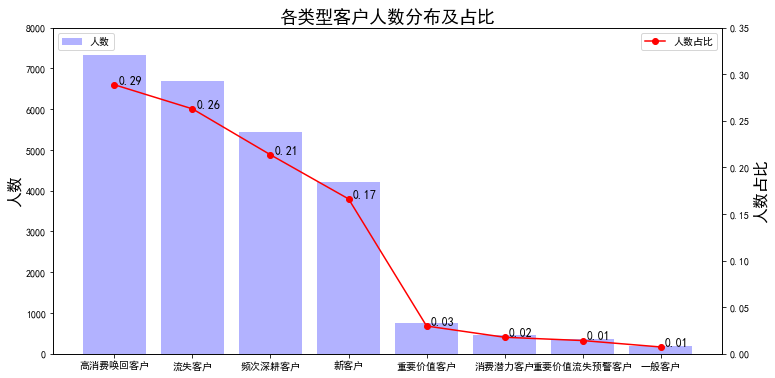

In [98]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']#用来显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

index = np.arange(8)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111) 
ax1.bar(index, result['人数'],color='b',alpha=0.3,label='人数')
ax1.set_ylim([0, 8000])  #设置y轴取值范围

ax2 = ax1.twinx() # this is the important function  
ax2.plot(index,result['人数占比'],'or-',label='人数占比')
ax2.set_ylim([0, 0.35])  #设置y轴取值范围
for i,(x,y) in enumerate(zip(index,result['人数占比'])):  
    plt.text(x+0.05,y+0.001,np.round(result['人数占比'][i],2),color='black',fontsize=12)  #将数值显示在图形上

plt.xticks(index,result['客户类型'])  #设置中文标签
# 坐标轴名称
#ax1.set_xlabel("客户",fontdict={'fontsize':16,'color':'black'})
ax1.set_ylabel('人数',fontdict={'fontsize':16,'color':'black'})
ax2.set_ylabel("人数占比",fontdict={'fontsize':16,'color':'black'})
#添加图例
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.title('各类型客户人数分布及占比',fontdict={'fontsize':18,'color':'black'})

从上面结果，我们可以快速得到一些推断：

客户流失情况严峻，高消费唤回客户、流失客户占比超过50%，怎么样制定针对性唤回策略迫在眉睫。
重要价值客户占比仅2.97%，还有三个客户占比甚至不足2%，我们模型打分可能不够科学，可以进一步调整打分区间进行优化。

Text(0.5, 1.0, '各类型客户消费金额及金额占比')

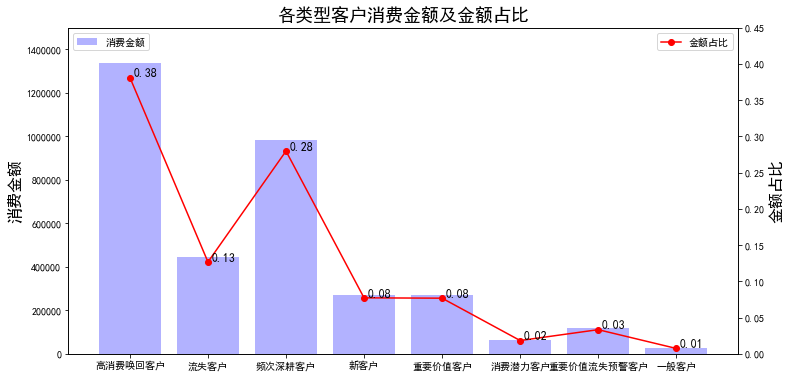

In [101]:
index = np.arange(8)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111) 
ax1.bar(index, result['消费金额'],color='b',alpha=0.3,label='消费金额')
ax1.set_ylim([0, 1500000])  #设置y轴取值范围

ax2 = ax1.twinx() # this is the important function  
ax2.plot(index,result['金额占比'],'or-',label='金额占比')
ax2.set_ylim([0, 0.45])  #设置y轴取值范围
for i,(x,y) in enumerate(zip(index,result['金额占比'])):  
    plt.text(x+0.05,y+0.001,np.round(result['金额占比'][i],2),color='black',fontsize=12)  #将数值显示在图形上

plt.xticks(index,result['客户类型'])  #设置中文标签
# 坐标轴名称
#ax1.set_xlabel("客户",fontdict={'fontsize':16,'color':'black'})
ax1.set_ylabel('消费金额',fontdict={'fontsize':16,'color':'black'})
ax2.set_ylabel("金额占比",fontdict={'fontsize':16,'color':'black'})
#添加图例
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.title('各类型客户消费金额及金额占比',fontdict={'fontsize':18,'color':'black'})

再结合金额进行分析：

高消费唤回客户人数占比28.87%，金额占比上升到了38.11%，这部分客户是消费的中流砥柱，他们为什么流失，应结合订单和购买行为数据进一步展开挖掘。
频次深耕客户金额占比紧随其后，这部分客户的特征是近期有消费、消费频次低、消费金额高，和高消费唤回客户仅有购买时间上的不同，如何避免这部分客户向高消费唤回客户的流转是我们要思考的主要命题。
流失客户人数占比26.28%，金额占比仅12.66%，这部分客户中有多少是褥羊毛用户，有多少是目标用户，对我们引流策略能够进行怎么样的指导和调整？

## 模型封装，一个回车就能返回结果

In [56]:
#输入源数据文件名
def get_rfm(name = './PYTHON-RFM实战数据.xlsx'):
    df = pd.read_excel(name)
    df = df.loc[df['订单状态'] == '交易成功',:]
    print('剔除退款后还剩:%d行' % len(df))
    df = df[['买家昵称','付款日期','实付金额']]

    r = df.groupby('买家昵称')['付款日期'].max().reset_index()
    r['R'] = (pd.to_datetime('2019-7-1') - r['付款日期']).dt.days
    r = r[['买家昵称','R']]

    #引入日期标签辅助列
    df['日期标签'] = df['付款日期'].astype(str).str[:10]

    #把单个用户一天内订单合并
    dup_f = df.groupby(['买家昵称','日期标签'])['付款日期'].count().reset_index()

    #对合并后的用户统计频次
    f = dup_f.groupby('买家昵称')['付款日期'].count().reset_index()
    f.columns = ['买家昵称','F']

    sum_m = df.groupby('买家昵称')['实付金额'].sum().reset_index()
    sum_m.columns = ['买家昵称','总支付金额']
    com_m = pd.merge(sum_m,f,left_on = '买家昵称',right_on = '买家昵称',how = 'inner')

    #计算用户平均支付金额
    com_m['M'] = com_m['总支付金额'] / com_m['F']

    rfm = pd.merge(r,com_m,left_on = '买家昵称',right_on = '买家昵称',how = 'inner')
    rfm = rfm[['买家昵称','R','F','M']]


    rfm['R-SCORE'] = pd.cut(rfm['R'],bins = [0,30,60,90,120,1000000],labels = [5,4,3,2,1],right = False).astype(float)
    rfm['F-SCORE'] = pd.cut(rfm['F'],bins = [1,2,3,4,5,1000000],labels = [1,2,3,4,5],right = False).astype(float)
    rfm['M-SCORE'] = pd.cut(rfm['M'],bins = [0,50,100,150,200,1000000],labels = [1,2,3,4,5],right = False).astype(float)

    rfm['R是否大于均值'] = (rfm['R-SCORE'] > rfm['R-SCORE'].mean()) * 1
    rfm['F是否大于均值'] = (rfm['F-SCORE'] > rfm['F-SCORE'].mean()) * 1
    rfm['M是否大于均值'] = (rfm['M-SCORE'] > rfm['M-SCORE'].mean()) * 1

    rfm['人群数值'] = (rfm['R是否大于均值'] * 100) + (rfm['F是否大于均值'] * 10) + (rfm['M是否大于均值'] * 1)

    rfm['人群类型'] = rfm['人群数值'].apply(transform_label)

    count = rfm['人群类型'].value_counts().reset_index()
    count.columns = ['客户类型','人数']
    count['人数占比'] = count['人数'] / count['人数'].sum()

    rfm['购买总金额'] = rfm['F'] * rfm['M']
    mon = rfm.groupby('人群类型')['购买总金额'].sum().reset_index()
    mon.columns = ['客户类型','消费金额']
    mon['金额占比'] = mon['消费金额'] / mon['消费金额'].sum()

    result = pd.merge(count,mon,left_on = '客户类型',right_on = '客户类型')

    return result


#判断R/F/M是否大于均值
def transform_label(x):
    if x == 111:
        label = '重要价值客户'
    elif x == 110:
        label = '消费潜力客户'
    elif x == 101:
        label = '频次深耕客户'
    elif x == 100:
        label = '新客户'
    elif x == 11:
        label = '重要价值流失预警客户'
    elif x == 10:
        label = '一般客户'
    elif x == 1:
        label = '高消费唤回客户'
    elif x == 0:
        label = '流失客户'
    return label

In [57]:
res = get_rfm(name = 'PYTHON-RFM实战数据.xlsx')
res

剔除退款后还剩:27793行


,客户类型,人数,人数占比,消费金额,金额占比
0,高消费唤回客户,7338,0.288670,1338153.0,0.381098
1,流失客户,6680,0.262785,444617.0,0.126624
2,频次深耕客户,5427,0.213493,981893.0,0.279638
3,新客户,4224,0.166168,270869.0,0.077142
4,重要价值客户,756,0.029740,269230.0,0.076675
5,消费潜力客户,450,0.017703,64075.0,0.018248
6,重要价值流失预警客户,360,0.014162,116665.0,0.033226
7,一般客户,185,0.007278,25803.0,0.007349
